In [2]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch import optim, nn, utils, Tensor, as_tensor
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import monai
import torchmetrics
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
import torch
import yaml
from dataset.hmri_dataset import HMRIDataModule
from models.pl_model import Model, get_3dresnet
from utils.utils import get_pretrained_model
from monai.data import ImageDataset, DataLoader
from monai.transforms import (
    LoadImage,
    ResizeWithPadOrCrop,
    RandCoarseShuffle,
    RandCoarseDropout,
    RandSpatialCropSamples,
    CropForeground,
    RandAdjustContrast,
    RandFlip,
    RandAffine,
    OneOf,
    EnsureChannelFirst, Compose, RandRotate90, Resize, ScaleIntensity
)
from monai.losses import ContrastiveLoss
# SimCLR
from simclr import SimCLR
from simclr.modules import NT_Xent
# from simclr.modules.transformations import TransformsSimCLR
from simclr.modules.sync_batchnorm import convert_model
this_path = Path().resolve()

2023-04-18 10:15:00,394 - Created a temporary directory at /tmp/tmphxtra_0p
2023-04-18 10:15:00,395 - Writing /tmp/tmphxtra_0p/_remote_module_non_scriptable.py


In [3]:
class HMRIDataModuleDownstream(HMRIDataModule):
    def __init__(self,
                md_df,
                root_dir,
                **kwargs):
        super().__init__(md_df,
                         root_dir,
                         **kwargs)
        
    def get_subjects_list(self, md_df):

        subjects_list = []
        subjects_labels = []
        md_df.reset_index(inplace=True, drop=True)

        for i in range(len(md_df)):

            # select the correct folder of masked volumes
            subj_dir = self.root_dir / md_df['id'][i] / 'Results' / self.masked
            subj_dir.exists()
            # get all windowed nifti volumes
            hmri_files = sorted(list(subj_dir.glob('*_w.nii')), key=lambda x: x.stem)

            # get only maps of interest
            hmri_files = [x for x in hmri_files if any(sub in x.stem for sub in self.map_type)]

            subjects_list.append(str(hmri_files[0]))
            subjects_labels.append(md_df['group'][i])

        return subjects_list, subjects_labels
    
    def prepare_data(self):

        subjs_to_drop = ['sub-058', 'sub-016']
        # if self.brain_masked:
        #     subjs_to_drop.append('sub-025')

        for drop_id in subjs_to_drop:
            self.md_df.drop(self.md_df[self.md_df.id == drop_id].index, inplace=True)
        self.md_df.reset_index(drop=True, inplace=True)
        print(f'Drop subjects {subjs_to_drop}')

        self.md_df_train, self.md_df_val = train_test_split(self.md_df, test_size=self.test_split, 
                                                            random_state=42, stratify=self.md_df.loc[:, 'group'].values)
        # self.md_df_train, self.md_df_val = train_test_split(md_df_train_, test_size=0.25,
        #                                         random_state=self.random_state, stratify=md_df_train_.loc[:, 'group'].values)
                                                
        self.train_subjects, self.labels_train = self.get_subjects_list(self.md_df_train)
        self.val_subjects, self.labels_val = self.get_subjects_list(self.md_df_val)

    def get_preprocessing_transform(self):

        preprocess = Compose([
                # LoadImage(),
                EnsureChannelFirst(),
                ScaleIntensity(minv=0, maxv=1),
                ResizeWithPadOrCrop(self.reshape_size, mode='minimum')
            ]
        )
        return preprocess
    
    def set_augmentation_transform(self):

        # If no augmentation is specified, use the default one
        if self.augment == None:
            self.augment = Compose([
                                    OneOf(
                                        transforms=[
                                        RandCoarseDropout(prob=1.0, holes=10, spatial_size=5, dropout_holes=True, max_spatial_size=32),
                                        RandCoarseDropout(prob=1.0, holes=15, spatial_size=20, dropout_holes=False, max_spatial_size=64),
                                        ]
                                    ),
                                    RandCoarseShuffle(prob=0.8, holes=20, spatial_size=20)
                                ]
                            )
            
    def setup(self, stage=None):
        
        # Assign train/val datasets for use in dataloaders
        self.preprocess = self.get_preprocessing_transform()
        self.set_augmentation_transform()
        self.transform = Compose([self.preprocess, self.augment])

        self.train_set = ImageDataset(image_files=self.train_subjects, 
                                      transform=self.transform,
                                      labels=self.labels_train)
        self.val_set = ImageDataset(image_files=self.val_subjects,
                                    transform=self.preprocess,
                                    labels=self.labels_val)

In [4]:
with open('./config/config_downstream.yaml', 'r') as f:
            cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

# Set data directory
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

# create PPMI dataset
augmentations = Compose([
                        RandAffine(
                            rotate_range=((-np.pi/12, np.pi/12), 0, (-np.pi/12, np.pi/12)), 
                            scale_range=((-0.2, 0.2), (-0.2, 0.2), (-0.2, 0.2)),
                    #    translate_range=((-12, 12), (-12, 12), (-12, 12)),
                            padding_mode="zeros",
                            prob=1, 
                            mode='bilinear'),
                        RandAdjustContrast(prob=1, gamma=(0.5, 2.0)),
                            ])
data = HMRIDataModuleDownstream(root_dir=root_dir,
                        md_df=md_df,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()


------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016']


In [4]:
data.val_num_workers

2

In [5]:
# print(f'Label: {data.train_set[0][1]}, img shape: {data.train_set[0][0].shape}')
im1, im1label = monai.utils.misc.first(data.val_dataloader())
print(im1.shape, im1label)

Label: 0, img shape: torch.Size([1, 180, 180, 180])
torch.Size([3, 1, 180, 180, 180]) tensor([1, 0, 1])


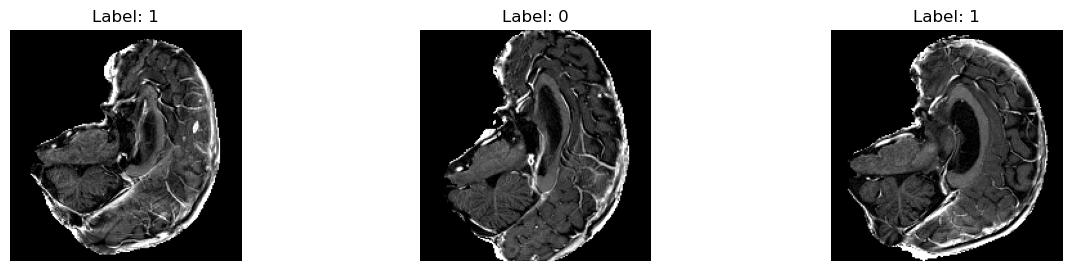

In [6]:
subj = 0
f,axs = plt.subplots(1,im1.shape[0], figsize=(15, 3))
for i in range(im1.shape[0]):
    axs[i].imshow(im1[i].cpu().detach().numpy()[0, :, :, 90], cmap='gray')
    axs[i].set_title(f'Label: {im1label[i]}')
    axs[i].axis('off')

In [8]:
def get_net(net):
    if net == 'resnet_monai':
        net = monai.networks.nets.ResNet('basic', layers=[1, 1, 1, 1], block_inplanes=[64, 128, 256, 512],
                                    spatial_dims=3, n_input_channels=1, num_classes=2)
    return net

class SimCLR(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the output after the average pooling layer.
    """

    def __init__(self, encoder, projection_dim):
        super(SimCLR, self).__init__()

        self.encoder = encoder
        self.n_features = self.encoder.fc.in_features

        # Replace the fc layer with an Identity function
        self.encoder.fc = nn.Identity()

        # We use a MLP with one hidden layer to obtain z_i = g(h_i) = W(2)σ(W(1)h_i) where σ is a ReLU non-linearity.
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False),
        )

    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)

        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        return h_i, h_j, z_i, z_j

class ContrastiveLearning(pl.LightningModule):
    def __init__(self, hpdict):
        
        super().__init__()

        self.hpdict = hpdict

        # initialize ResNet
        # self.encoder = get_net(self.hpdict['model']['net'])
        # self.n_features = self.encoder.fc.in_features  # get dimensions of fc layer
        self.model = SimCLR(get_net(self.hpdict['model']['net']), self.hpdict['model']['projection_dim'])
        self.criterion = ContrastiveLoss(self.hpdict['model']['temperature'])

    def forward(self, x_i, x_j):
        h_i, h_j, z_i, z_j = self.model(x_i, x_j)
        loss = self.criterion(z_i, z_j)
        return loss

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x_i, x_j = batch
        loss = self.forward(x_i, x_j)
        self.log("train_loss", 
                 loss, on_step=False, 
                 on_epoch=True,
                 prog_bar=True, 
                 logger=True, 
                 batch_size=self.hpdict['dataset']['train_batch_size'])
        return loss
    
    def validation_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x_i, x_j = batch
        loss = self.forward(x_i, x_j)
        self.log("val_loss", 
                 loss, on_step=False, 
                 on_epoch=True,
                 prog_bar=True, 
                 logger=True, 
                 batch_size=self.hpdict['dataset']['train_batch_size'])
        return loss

    def configure_criterion(self):
        # criterion = NT_Xent(self.hpdict['dataset']['batch_size'], self.hpdict['model']['temperature'])
        criterion = ContrastiveLoss(temperature=self.hpdict['model']['temperature'])
        return criterion

    def configure_optimizers(self):
        scheduler = None
        if self.hpdict['model']['optimizer_class'] == "adam":
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hpdict['model']['learning_rate'])
                    # "decay the learning rate with the cosine decay schedule without restarts"
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, self.hpdict['pl_trainer']['max_epochs'], eta_min=0, last_epoch=-1
            )
        else:
            raise NotImplementedError

        if scheduler:
            return {"optimizer": optimizer, "lr_scheduler": scheduler}
        else:
            return {"optimizer": optimizer}

In [9]:
# create model
# load config file
chkpt_path = Path(cfg['model']['chkpt_path'])
exp_dir = chkpt_path.parent.parent.parent
with open(exp_dir /'config_dump.yml', 'r') as f:
    exp_cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

pretrained_model = ContrastiveLearning.load_from_checkpoint(chkpt_path, hpdict=exp_cfg)

In [11]:
for n,m in pretrained_model.model.named_children():
    print(n)
# layers = list(pretrained_model.model.children())[:-1]
# feature_extractor = nn.Sequential(*layers)
# feature_extractor
# print(pretrained_model.model.projector[0].in_features)

encoder
projector


In [12]:
pretrained_model.model.encoder

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResNetBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine

In [9]:
class ClassifierSimCLR(nn.Module):
    def __init__(self, net, num_classes):
        super().__init__()

        n_features = self.net.projector[0].in_features
        self.feature_extractor = nn.Sequential(*list(net.children())[:-1])

        self.classifier = nn.Sequential(
                            nn.Dropout(0.5),
                            nn.Linear(n_features, 256),
                            nn.ReLU(),
                            nn.Linear(256, 2)
                        )
        
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

class ModelDownstream(Model):
    def __init__(self, 
                 net=None,
                 **kwargs):
        super().__init__(net=net, **kwargs)

        self.save_hyperparameters(ignore=['net'])
        self.net = ClassifierSimCLR(self.net, 2)
    
    def forward(self, x):
        y_hat = self.net(x)
        return y_hat

    def training_step(self, batch, batch_idx):
            x, y = batch
            batch_size = len(y)
            y_hat = self.forward(x)
            loss = self.criterion(y_hat, y)
            self.log("train_loss", loss, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
            self.train_acc(y_hat, y)
            self.train_auroc(y_hat, y)
            self.train_f1(y_hat, y)
            self.log("train_acc", self.train_acc, on_step=False, on_epoch=True ,prog_bar=False, logger=True, batch_size=batch_size)
            self.log("train_auroc", self.train_auroc, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
            self.log("train_f1", self.train_f1, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
            
            return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        batch_size = len(y)
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.val_acc(y_hat, y)
        self.val_auroc(y_hat, y)
        self.val_f1(y_hat, y)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True ,prog_bar=False, logger=True, batch_size=batch_size)
        self.log("val_auroc", self.val_auroc, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_f1", self.val_f1, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        return loss

class ModelDownstream(Model):
    def __init__(self, 
                 get_encoder=None,
                 net=None,
                 **kwargs):
        super().__init__(net=net, **kwargs)

        self.save_hyperparameters(ignore=['net'])
        if get_encoder is not None:
            self.feature_extractor, n_features = get_encoder(self.net)
        else:
            n_features = self.net.projector[0].in_features
            layers = list(self.net.children())[:-1]
            self.feature_extractor = nn.Sequential(*layers)
        
        self.classifier = nn.Linear(n_features, 2)
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)
    
    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x)
        y_hat = self.classifier(representations)
        return y_hat
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        batch_size = len(y)
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y).mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.train_acc(y_hat, y)
        self.train_auroc(y_hat, y)
        self.train_f1(y_hat, y)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True ,prog_bar=False, logger=True, batch_size=batch_size)
        self.log("train_auroc", self.train_auroc, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.log("train_f1", self.train_f1, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
           
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        batch_size = len(y)
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y).mean()
        self.log("val_loss", loss, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.val_acc(y_hat, y)
        self.val_auroc(y_hat, y)
        self.val_f1(y_hat, y)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True ,prog_bar=False, logger=True, batch_size=batch_size)
        self.log("val_auroc", self.val_auroc, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_f1", self.val_f1, on_step=False, on_epoch=True ,prog_bar=True, logger=True, batch_size=batch_size)
        return loss

In [76]:
cfg['model']

{'chkpt_path': "/mrhome/alejandrocu/Documents/parkinson_classification/p3_ssl_hmri/04_rs120_ssl_simclr_resnet/version_0/checkpoints/epoch=116-val_loss=tensor(0.5363, device='cuda:0').ckpt",
 'n_classes': 2,
 'in_channels': 1,
 'loss': 'focal',
 'alpha': 0.35,
 'optimizer_class': 'adam',
 'group_params': False,
 'learning_rate': 0.001,
 'sch_patience': 0,
 'momentum': 0,
 'weight_decay': 0.0001}

In [10]:
model = ModelDownstream(net=pretrained_model.model, **cfg['model'])

In [12]:
out = model.forward(im1)
out.shape

torch.Size([3, 2])

In [16]:
data.labels_val

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]

In [19]:
nn.functional.one_hot(torch.tensor(0), num_classes=2)

tensor([1, 0])

In [13]:
model.criterion(out, im1label)

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 1

In [78]:
model.net

SimCLR(
  (encoder): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNetBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (layer2): Sequential(
      (0): ResNetBlock(
        (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
        

In [ ]:
model = Model(net=pretrained_model.net, **cfg['model'])

In [43]:
from monai.losses import ContrastiveLoss

# SimCLR
# from simclr import SimCLR
# from simclr.modules import NT_Xent

def get_net(net):
    if net == 'resnet_monai':
        net = monai.networks.nets.ResNet('basic', layers=[1, 1, 1, 1], block_inplanes=[64, 128, 256, 512],
                                    spatial_dims=3, n_input_channels=1, num_classes=2)
    return net

class SimCLR(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the output after the average pooling layer.
    """

    def __init__(self, encoder, projection_dim):
        super(SimCLR, self).__init__()

        self.encoder = encoder
        self.n_features = self.encoder.fc.in_features

        # Replace the fc layer with an Identity function
        self.encoder.fc = nn.Identity()

        # We use a MLP with one hidden layer to obtain z_i = g(h_i) = W(2)σ(W(1)h_i) where σ is a ReLU non-linearity.
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False),
        )

    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)

        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        return h_i, h_j, z_i, z_j

class ContrastiveLearning(pl.LightningModule):
    def __init__(self, hpdict):
        
        super().__init__()

        self.hpdict = hpdict

        # initialize ResNet
        # self.encoder = get_net(self.hpdict['model']['net'])
        # self.n_features = self.encoder.fc.in_features  # get dimensions of fc layer
        self.model = SimCLR(get_net(self.hpdict['model']['net']), self.hpdict['model']['projection_dim'])
        self.criterion = ContrastiveLoss(self.hpdict['model']['temperature'])

    def forward(self, x_i, x_j):
        h_i, h_j, z_i, z_j = self.model(x_i, x_j)
        loss = self.criterion(z_i, z_j)
        return loss

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x_i, x_j = batch
        loss = self.forward(x_i, x_j)
        self.log("train_loss", 
                 loss, on_step=False, 
                 on_epoch=True,
                 prog_bar=True, 
                 logger=True, 
                 batch_size=self.hpdict['dataset']['train_batch_size'])
        return loss
    
    def validation_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x_i, x_j = batch
        loss = self.forward(x_i, x_j)
        self.log("val_loss", 
                 loss, on_step=False, 
                 on_epoch=True,
                 prog_bar=True, 
                 logger=True, 
                 batch_size=self.hpdict['dataset']['train_batch_size'])
        return loss

    def configure_criterion(self):
        # criterion = NT_Xent(self.hpdict['dataset']['batch_size'], self.hpdict['model']['temperature'])
        criterion = ContrastiveLoss(temperature=self.hpdict['model']['temperature'])
        return criterion

    def configure_optimizers(self):
        scheduler = None
        if self.hpdict['model']['optimizer_class'] == "adam":
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hpdict['model']['learning_rate'])
                    # "decay the learning rate with the cosine decay schedule without restarts"
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, self.hpdict['pl_trainer']['max_epochs'], eta_min=0, last_epoch=-1
            )
        else:
            raise NotImplementedError

        if scheduler:
            return {"optimizer": optimizer, "lr_scheduler": scheduler}
        else:
            return {"optimizer": optimizer}

class HMRIDataCLR(pl.LightningDataModule):
    def __init__(self, 
                md_df, 
                root_dir,
                train_batch_size = 4,
                val_batch_size = 4,
                train_num_workers = 4,
                val_num_workers = 4, 
                reshape_size = (128, 128, 128), 
                test_split = 0.2, 
                random_state = 42,
                map_type = ['MTsat'],
                windowed_dataset = False,
                masked = 'brain_masked',
                weighted_sampler = False,
                augment = None,
                shuffle = True):
        super().__init__()
        self.md_df = md_df
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.train_num_workers = train_num_workers
        self.val_num_workers = val_num_workers
        self.root_dir = root_dir
        self.reshape_size = reshape_size
        self.test_split = test_split
        self.random_state = random_state
        self.map_type = map_type
        self.windowed_dataset = windowed_dataset
        self.masked = masked
        self.weighted_sampler = weighted_sampler
        self.augment = augment
        self.shuffle = shuffle
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None

    def get_subjects_list(self, md_df):

        subjects_list = []
        # subjects_labels = []
        md_df.reset_index(inplace=True, drop=True)

        for i in range(len(md_df)):

            # select the correct folder of masked volumes
            subj_dir = self.root_dir / md_df['id'][i] / 'Results' / self.masked
            subj_dir.exists()
            # get all windowed nifti volumes
            hmri_files = sorted(list(subj_dir.glob('*_w.nii')), key=lambda x: x.stem)

            # get only maps of interest
            hmri_files = [x for x in hmri_files if any(sub in x.stem for sub in self.map_type)]

            subjects_list.append(str(hmri_files[0]))
            # subjects_labels.append(md_df['group'][i])

        return subjects_list #, subjects_labels

    def prepare_data(self):

        # split ratio train = 0.6, val = 0.2, test = 0.2

        # drop subject 058 because it doesn't have maps
        # 'sub-016' has PD* map completely black
        # sub-025 has no brain mask
        subjs_to_drop = ['sub-058', 'sub-016']
        # if self.brain_masked:
        #     subjs_to_drop.append('sub-025')

        for drop_id in subjs_to_drop:
            self.md_df.drop(self.md_df[self.md_df.id == drop_id].index, inplace=True)
        self.md_df.reset_index(drop=True, inplace=True)
        print(f'Drop subjects {subjs_to_drop}')

        self.md_df_train, self.md_df_val = train_test_split(self.md_df, test_size=self.test_split, 
                                                            random_state=42, stratify=self.md_df.loc[:, 'group'].values)
        # self.md_df_train, self.md_df_val = train_test_split(md_df_train_, test_size=0.25,
        #                                         random_state=self.random_state, stratify=md_df_train_.loc[:, 'group'].values)
                                                
        self.train_subjects = self.get_subjects_list(self.md_df_train)
        self.val_subjects = self.get_subjects_list(self.md_df_val)

        # self.test_subjects = []
        # for image_path, label in zip(image_test_paths, labels_test):
        #     subject = tio.Subject(image=tio.ScalarImage(image_path), label=nn.functional.one_hot(as_tensor(label), num_classes=2).float())
        #     self.test_subjects.append(subject)

    def get_preprocessing_transform(self):

        preprocess = Compose([
                # LoadImage(),
                EnsureChannelFirst(),
                ScaleIntensity(minv=0, maxv=1),
                ResizeWithPadOrCrop(self.reshape_size, mode='minimum')
            ]
        )
        return preprocess

    def get_augmentation_transform(self):

        # If no augmentation is specified, use the default one
        if self.augment == None:
            self.augment = tio.Compose([
                                        tio.RandomAffine(),
                                        tio.RandomGamma(p=0.5),
                                        tio.RandomNoise(p=0.5),
                                        tio.RandomMotion(p=0.1),
                                        tio.RandomBiasField(p=0.25),
                                        ])

    def setup(self, stage=None):
        
        # Assign train/val datasets for use in dataloaders
        self.preprocess = self.get_preprocessing_transform()
        self.get_augmentation_transform()
        self.transform = self.augment #Compose([self.preprocess, self.augment])

        self.train_set = ImageDataset(image_files=self.train_subjects, 
                                      transform=self.transform,
                                      image_only=True)
        self.val_set = ImageDataset(image_files=self.val_subjects,
                                    transform=self.transform,
                                    image_only=True)
        # self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, 
                            batch_size=self.train_batch_size, 
                            num_workers=self.train_num_workers,
                            shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_set,
                            batch_size=self.val_batch_size, 
                            num_workers=self.val_num_workers,
                            shuffle=False)

class TransformsSimCLR:

    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, reshape_size):
        
        self.preprocess = Compose([
                # LoadImage(),
                EnsureChannelFirst(),
                ScaleIntensity(minv=0, maxv=1),
                ResizeWithPadOrCrop(reshape_size, mode='minimum'),
                # CropForeground(margin=0),

            ]
        )
        self.augment = Compose([
                RandFlip(prob=0.5, spatial_axis=0),
                RandFlip(prob=0.5, spatial_axis=1),
                RandFlip(prob=0.5, spatial_axis=2),
                RandAffine(
                        # rotate_range=((-np.pi/12, np.pi/12), (-np.pi/12, np.pi/12), (-np.pi/12, np.pi/12)), 
                    #    scale_range=((1, 1.1), (1, 1.1), (1, 1.1)),
                       translate_range=((-12, 12), (-12, 12), (-12, 12)),
                       padding_mode="zeros",
                       prob=1, 
                       mode='bilinear'),
                OneOf(
                    transforms=[
                    RandCoarseDropout(prob=1.0, holes=8, spatial_size=5, dropout_holes=True, max_spatial_size=32),
                    RandCoarseDropout(prob=1.0, holes=12, spatial_size=20, dropout_holes=False, max_spatial_size=64),
                    ]
                ),
                RandCoarseShuffle(prob=0.8, holes=20, spatial_size=20)
            ]
        )

        self.train_transform = Compose([self.preprocess, self.augment])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)
    

In [79]:
def get_net(net):
    if net == 'resnet_monai':
        net = monai.networks.nets.ResNet('basic', layers=[1, 1, 1, 1], block_inplanes=[64, 128, 256, 512],
                                    spatial_dims=3, n_input_channels=1, num_classes=2)
    return net

class ContrastiveLearning(pl.LightningModule):
    def __init__(self, hpdict):
        
        super().__init__()

        self.hpdict = hpdict

        # initialize ResNet
        self.encoder = get_net(self.hpdict['model']['net'])
        self.n_features = self.encoder.fc.in_features  # get dimensions of fc layer
        self.model = SimCLR(self.encoder, self.hpdict['model']['projection_dim'], self.n_features)
        self.criterion = NT_Xent(
            self.hpdict['dataset']['train_batch_size'], self.hpdict['model']['temperature'], world_size=1
        )

    def forward(self, x_i, x_j):
        h_i, h_j, z_i, z_j = self.model(x_i, x_j)
        loss = self.criterion(z_i, z_j)
        return loss

    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x_i, x_j = batch
        loss = self.forward(x_i, x_j)
        self.log("train_loss", 
                 loss, on_step=False, 
                 on_epoch=True,
                 prog_bar=True, 
                 logger=True, 
                 batch_size=self.hpdict['dataset']['train_batch_size'])
        return loss
    
    def validation_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        x_i, x_j = batch
        loss = self.forward(x_i, x_j)
        self.log("val_loss", 
                 loss, on_step=False, 
                 on_epoch=True,
                 prog_bar=True, 
                 logger=True, 
                 batch_size=self.hpdict['dataset']['train_batch_size'])
        return loss

    def configure_criterion(self):
        criterion = NT_Xent(self.hpdict['dataset']['batch_size'], self.hpdict['model']['temperature'])
        return criterion

    def configure_optimizers(self):
        scheduler = None
        if self.hpdict['model']['optimizer_class'] == "adam":
            optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hpdict['model']['learning_rate'])
                    # "decay the learning rate with the cosine decay schedule without restarts"
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, self.hpdict['pl_trainer']['max_epochs'], eta_min=0, last_epoch=-1
            )
        else:
            raise NotImplementedError

        if scheduler:
            return {"optimizer": optimizer, "lr_scheduler": scheduler}
        else:
            return {"optimizer": optimizer}

In [52]:
class HMRIDataCLR(pl.LightningDataModule):
    def __init__(self, 
                md_df, 
                root_dir,
                train_batch_size = 4,
                val_batch_size = 4,
                train_num_workers = 4,
                val_num_workers = 4, 
                reshape_size = (128, 128, 128), 
                test_split = 0.2, 
                random_state = 42,
                map_type = ['MTsat'],
                windowed_dataset = False,
                masked = 'brain_masked',
                weighted_sampler = False,
                augment = None,
                shuffle = True):
        super().__init__()
        self.md_df = md_df
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.train_num_workers = train_num_workers
        self.val_num_workers = val_num_workers
        self.root_dir = root_dir
        self.reshape_size = reshape_size
        self.test_split = test_split
        self.random_state = random_state
        self.map_type = map_type
        self.windowed_dataset = windowed_dataset
        self.masked = masked
        self.weighted_sampler = weighted_sampler
        self.augment = augment
        self.shuffle = shuffle
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.transform = None
        self.train_set = None
        self.val_set = None
        self.test_set = None

    def get_subjects_list(self, md_df):

        subjects_list = []
        # subjects_labels = []
        md_df.reset_index(inplace=True, drop=True)

        for i in range(len(md_df)):

            # select the correct folder of masked volumes
            subj_dir = self.root_dir / md_df['id'][i] / 'Results' / self.masked
            subj_dir.exists()
            # get all windowed nifti volumes
            hmri_files = sorted(list(subj_dir.glob('*_w.nii')), key=lambda x: x.stem)

            # get only maps of interest
            hmri_files = [x for x in hmri_files if any(sub in x.stem for sub in self.map_type)]

            subjects_list.append(str(hmri_files[0]))
            # subjects_labels.append(md_df['group'][i])

        return subjects_list #, subjects_labels

    def prepare_data(self):

        # split ratio train = 0.6, val = 0.2, test = 0.2

        # drop subject 058 because it doesn't have maps
        # 'sub-016' has PD* map completely black
        # sub-025 has no brain mask
        subjs_to_drop = ['sub-058', 'sub-016']
        # if self.brain_masked:
        #     subjs_to_drop.append('sub-025')

        for drop_id in subjs_to_drop:
            self.md_df.drop(self.md_df[self.md_df.id == drop_id].index, inplace=True)
        self.md_df.reset_index(drop=True, inplace=True)
        print(f'Drop subjects {subjs_to_drop}')

        self.md_df_train, self.md_df_val = train_test_split(self.md_df, test_size=self.test_split, 
                                                            random_state=42, stratify=self.md_df.loc[:, 'group'].values)
        # self.md_df_train, self.md_df_val = train_test_split(md_df_train_, test_size=0.25,
        #                                         random_state=self.random_state, stratify=md_df_train_.loc[:, 'group'].values)
                                                
        self.train_subjects = self.get_subjects_list(self.md_df_train)
        self.val_subjects = self.get_subjects_list(self.md_df_val)

        # self.test_subjects = []
        # for image_path, label in zip(image_test_paths, labels_test):
        #     subject = tio.Subject(image=tio.ScalarImage(image_path), label=nn.functional.one_hot(as_tensor(label), num_classes=2).float())
        #     self.test_subjects.append(subject)

    def get_preprocessing_transform(self):

        preprocess = Compose([
                # LoadImage(),
                EnsureChannelFirst(),
                ScaleIntensity(minv=0, maxv=1),
                ResizeWithPadOrCrop(self.reshape_size, mode='minimum')
            ]
        )
        return preprocess

    def get_augmentation_transform(self):

        # If no augmentation is specified, use the default one
        if self.augment == None:
            self.augment = tio.Compose([
                                        tio.RandomAffine(),
                                        tio.RandomGamma(p=0.5),
                                        tio.RandomNoise(p=0.5),
                                        tio.RandomMotion(p=0.1),
                                        tio.RandomBiasField(p=0.25),
                                        ])

    def setup(self, stage=None):
        
        # Assign train/val datasets for use in dataloaders
        self.preprocess = self.get_preprocessing_transform()
        self.get_augmentation_transform()
        self.transform = self.augment #Compose([self.preprocess, self.augment])

        self.train_set = ImageDataset(image_files=self.train_subjects, 
                                      transform=self.transform,
                                      image_only=True)
        self.val_set = ImageDataset(image_files=self.val_subjects,
                                    transform=self.transform,
                                    image_only=True)
        # self.test_set = tio.SubjectsDataset(self.test_subjects, transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, 
                            batch_size=self.train_batch_size, 
                            num_workers=self.train_num_workers,
                            shuffle=self.shuffle)

    def val_dataloader(self):
        return DataLoader(self.val_set,
                            batch_size=self.val_batch_size, 
                            num_workers=self.val_num_workers,
                            shuffle=False)

class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, reshape_size):
        
        self.preprocess = Compose([
                # LoadImage(),
                EnsureChannelFirst(),
                ScaleIntensity(minv=0, maxv=1),
                ResizeWithPadOrCrop(reshape_size, mode='minimum')
            ]
        )
        self.augment = Compose([
                OneOf(
                    transforms=[
                    RandCoarseDropout(prob=1.0, holes=10, spatial_size=5, dropout_holes=True, max_spatial_size=32),
                    RandCoarseDropout(prob=1.0, holes=15, spatial_size=20, dropout_holes=False, max_spatial_size=64),
                    ]
                ),
                RandCoarseShuffle(prob=0.8, holes=20, spatial_size=20)
            ]
        )

        self.train_transform = Compose([self.preprocess, self.augment])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

In [44]:
with open('./config/configssl.yaml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

# Set data directory
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

# create PPMI dataset
augmentations = TransformsSimCLR(reshape_size=cfg['dataset']['reshape_size'])
data = HMRIDataCLR(root_dir=root_dir,
                        md_df=md_df,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()

------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016']


In [45]:
im1, im2 = monai.utils.misc.first(data.train_dataloader())
print(type(im1), im1.shape)

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([4, 1, 120, 120, 120])


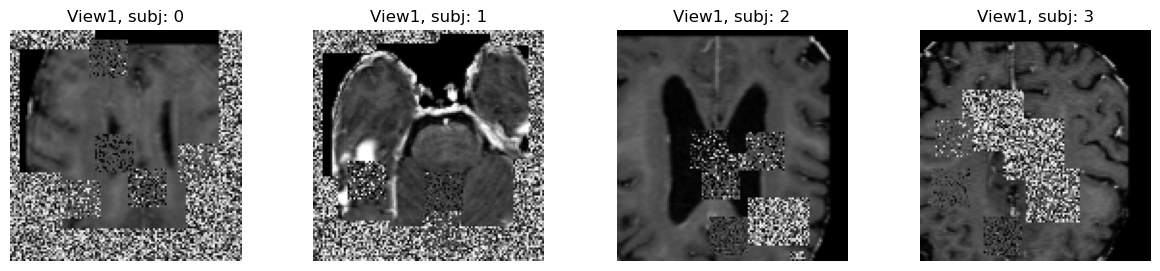

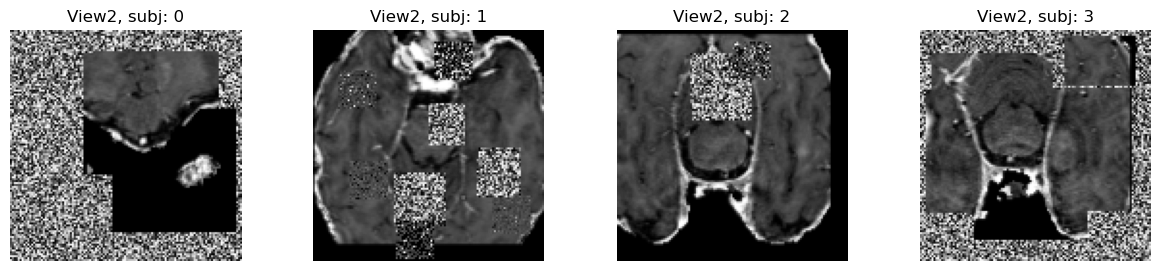

In [47]:
subj = 0
f,axs = plt.subplots(1,im1.shape[0], figsize=(15, 3))
for i in range(im1.shape[0]):
    axs[i].imshow(im1[i].cpu().detach().numpy()[0, :,90, :], cmap='gray')
    axs[i].set_title(f'View1, subj: {i}')
    axs[i].axis('off')
    subj = 0

f,axs = plt.subplots(1,im2.shape[0], figsize=(15, 3))
for i in range(im2.shape[0]):
    axs[i].imshow(im2[i].cpu().detach().numpy()[0, :, 90, :], cmap='gray')
    axs[i].set_title(f'View2, subj: {i}')
    axs[i].axis('off')

In [4]:
clmodel = ContrastiveLearning(cfg)

checkpoint_callback = pl.callbacks.ModelCheckpoint(save_top_k=5,
                                          monitor=cfg['training']['monitor_ckpt'],
                                          mode="min",
                                          filename="{epoch:02d}-{val_loss:.4f}")
# create loggers
tb_logger = TensorBoardLogger(save_dir=Path('./p3_ssl_hmri'),
                            name=cfg['exp_name'])

# save the config file to the output folder
# for a given experiment
dump_path = Path('./p3_ssl_hmri').resolve() / f'{cfg["exp_name"]}'
dump_path.mkdir(parents=True, exist_ok=True)
dump_path = dump_path/'config_dump.yml'
with open(dump_path, 'w') as f:
    yaml.dump(cfg, f)

In [ ]:
# create trainer
trainer = pl.Trainer(**cfg['pl_trainer'],
                    callbacks=checkpoint_callback,
                    logger=[tb_logger],
                    )

start = datetime.now()
# print("Training started at", start)
trainer.fit(model=clmodel, datamodule=data)
print("Training duration:", datetime.now() - start)